# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import FCN
from vbranch.applications.cnn import CNN, CNNCifar10
from vbranch.applications.resnet import ResNet18
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import *
from vbranch.utils.generic import get_path, save_results

Using TensorFlow backend.


In [3]:
MODEL_ID = 1
ARCHITECTURE = 'cnn'
DATASET = 'cifar10'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.0
TRAIN_FRAC = 1.

BATCH_SIZE = 32
EPOCHS = 100
T_0 = 50
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC, preprocess=True)
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
print(X_train.min(), X_train.max())

-1.0 1.0


In [7]:
class Generator(object):
    def __init__(self, X, Y, batch_size):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    
    def __next__(self):
        choice = np.random.choice(len(X), self.batch_size, replace=False)
        return self.X[choice], self.Y[choice]

## Training

In [8]:
def path(n_branches, shared_frac):
    return get_path(DATASET, ARCHITECTURE, 'sensitivity-Ba32', vb=True, 
                    B=n_branches, S=shared_frac)

In [9]:
def build_model(n_branches, shared_frac, name='model', compile_loss=True):
    inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    n=n_branches, 
                                                                    share_xy=BAGGING_SAMPLES == 0)
    print(inputs, labels)
    lr = tf.placeholder('float32', name='lr')
    lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)
    
#     with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
#         if ARCHITECTURE == 'fcn':
#             layer_spec = [(512, shared_frac), NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2':
#             layer_spec = [(512, shared_frac), 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn3':
#             layer_spec = [(512, shared_frac), 512, 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         elif ARCHITECTURE == 'fcn3A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), 
#                           (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         else:
#             raise ValueError('invalid model')
            
#         model = FCN(inputs, *layer_spec, name=name, shared_frac=1)

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'cnn':
            layers = [32, 64, 128]
        elif ARCHITECTURE == 'cnnx':
            layers = [(32, shared_frac), (64, 1.0), (128, 1.0)]
        else:
            raise ValueError('invalid model')
        model = CNN(inputs, NUM_CLASSES, *layers, name=name, 
                    shared_frac=shared_frac, n_layers=2)
#         model = ResNet18(inputs, NUM_CLASSES, name=name, shared_frac=shared_frac)
    
        if compile_loss:
            optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                          train_init_op, test_init_op, labels=labels,
                          callbacks={'acc':classification_acc(n_branches)}, 
                          schedulers={'lr:0': lr_scheduler})

    return model

In [10]:
def train(n_branches, shared_frac, model_id=1):
    dirpath = path(n_branches, shared_frac)
    model_path = os.path.join('models', dirpath, 'model_{}'.format(model_id))
    os.system('mkdir -p ' + model_path)
    print(model_path)
    
    tf.reset_default_graph()
    model = build_model(n_branches, shared_frac)
    model.summary()
    
    # Bagging
    if BAGGING_SAMPLES > 0:
        x_train_list, y_train_list = bag_samples(X_train, y_train, n_branches, 
                                                 max_samples=BAGGING_SAMPLES)
    
    train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}
    
    if n_branches > 1 and BAGGING_SAMPLES > 0:
        print('Bag', BAGGING_SAMPLES)
        for i in range(n_branches):
            train_dict[f'vb{i+1}_x:0'] = x_train_list[i]
            train_dict[f'vb{i+1}_y:0'] = y_train_list[i]

    history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                        val_dict=val_dict, log_path=model_path)
    save_results(history, dirpath, f'train_{model_id}.csv')
    
    return history

In [ ]:
for n_branches in range(3, 5):
    for shared_frac in [0.5, 0.75, 1.]:
        for t in range(4):
            train(n_branches, shared_frac, model_id=t+1)
# history = train(n_branches=2, shared_frac=1.0)

models/sensitivity-Ba32/vb-cifar10-cnn/B3/S0.50/model_1
Instructions for updating:
Colocations handled automatically by placer.
[<tf.Tensor 'input:0' shape=(?, 32, 32, 3) dtype=float32>, <tf.Tensor 'input_1:0' shape=(?, 32, 32, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 32, 32, 3) dtype=float32>] [<tf.Tensor 'input:1' shape=(?, 10) dtype=float32>, <tf.Tensor 'input_1:1' shape=(?, 10) dtype=float32>, <tf.Tensor 'input_2:1' shape=(?, 10) dtype=float32>]
Instructions for updating:
Use tf.cast instead.
i   Layer name                      Output shape                     Num param  Inbound            
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                     

Bag 1.0
Epoch 1/100
(500, 10)
(10000, 10)
 - 21s - lr:0: 0.0010 - loss_1: 1.9237 - loss_2: 1.9411 - loss_3: 1.9412 - acc_ensemble: 0.4100 - acc_1: 0.3740 - acc_2: 0.3600 - acc_3: 0.3320 - val_loss_1: 1.6811 - val_loss_2: 1.6969 - val_loss_3: 1.7341 - val_acc_ensemble: 0.4048 - val_acc_1: 0.3717 - val_acc_2: 0.3742 - val_acc_3: 0.3530
Epoch 2/100
(500, 10)
(10000, 10)
 - 84s - lr:0: 0.0010 - loss_1: 1.6504 - loss_2: 1.6988 - loss_3: 1.6697 - acc_ensemble: 0.4740 - acc_1: 0.4180 - acc_2: 0.4320 - acc_3: 0.4120 - val_loss_1: 1.5657 - val_loss_2: 1.5885 - val_loss_3: 1.6151 - val_acc_ensemble: 0.4495 - val_acc_1: 0.4240 - val_acc_2: 0.4100 - val_acc_3: 0.3995
Epoch 3/100
(500, 10)
(10000, 10)
 - 68s - lr:0: 0.0010 - loss_1: 1.5280 - loss_2: 1.5685 - loss_3: 1.5894 - acc_ensemble: 0.5280 - acc_1: 0.4720 - acc_2: 0.4720 - acc_3: 0.4900 - val_loss_1: 1.4282 - val_loss_2: 1.4518 - val_loss_3: 1.4582 - val_acc_ensemble: 0.5071 - val_acc_1: 0.4693 - val_acc_2: 0.4673 - val_acc_3: 0.4613
Epoch 4/

## Evaluation

In [9]:
# from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits
import json

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [10]:
def correlation_strength(n_branches, shared_frac, model_id):
    model_path = os.path.join('models', path(n_branches, shared_frac), 
                              'model_{}'.format(model_id))
    print(model_path)

    test_init_ops = []
    tensors = []
    for i in range(n_branches):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        tensors.append('model/output/vb{}/output:0'.format(i+1))

    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                           'batch_size:0':len(X_test)})
        outputs = sess.run(tensors)

    return compute_correlation_strength(outputs, y_test, NUM_CLASSES, n_branches)

In [11]:
correlation_results = {}
strength_results = {}

# num_branches = 4
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
# shared_correlation_list = []
# shared_strength_list = []
n_trials = 4

for b in range(2, 3):
    correlation_results[b] = {}
    strength_results[b] = {}
    
    for shared in shared_frac_list:
        correlation_list = []
        strength_list = []

        for model_id in range(1, n_trials + 1):
            tf.reset_default_graph()
            c, s = correlation_strength(b, shared, model_id)
            correlation_list.append(c)
            strength_list.append(s)

        correlation_results[b][shared] = [np.mean(correlation_list), np.std(correlation_list)]
        strength_results[b][shared] = [np.mean(strength_list), np.std(strength_list)]

models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_1
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_1/ckpt
[0.6525 0.653 ]
models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_2
INFO:tensorflow:Restoring parameters from models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_2/ckpt
[0.6434 0.6534]
models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_3
INFO:tensorflow:Restoring parameters from models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_3/ckpt
[0.6438 0.6531]
models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_4
INFO:tensorflow:Restoring parameters from models/sensitivity-3/vb-cifar10-cnn/B2/S0.00/model_4/ckpt
[0.6465 0.6445]
models/sensitivity-3/vb-cifar10-cnn/B2/S0.25/model_1
INFO:tensorflow:Restoring parameters from models/sensitivity-3/vb-cifar10-cnn/B2/S0.25/model_1/ckpt
[0.6578 0.6485]
models/sensitivity-3/vb-cifar10-cnn/B2/S0.25/model_2
INFO:tensorflow

In [12]:
with open(f'results/sensitivity-3/correlation-{DATASET}-{ARCHITECTURE}.json', 'w') as f:
    json.dump(correlation_results, f, indent=4)
with open(f'results/sensitivity-3/strength-{DATASET}-{ARCHITECTURE}.json', 'w') as f:
    json.dump(strength_results, f, indent=4)

In [16]:
architecture = ['cnn'] #, 'cnnx'] #, 'fcn2', 'fcn3', 'fcn2A', 'fcn3A']
correlation = []
strength = []

for arch in architecture:
    with open(f'results/sensitivity-3/correlation-{DATASET}-{arch}.json', 'r') as f:
        correlation.append(json.load(f))
    with open(f'results/sensitivity-3/strength-{DATASET}-{arch}.json', 'r') as f:
        strength.append(json.load(f))

In [17]:
def plot_corr_strength(n_branches):
    def mean_std(data):
        mean = []
        std = []
        for frac in shared_frac_list:
            mean.append(data[str(frac)][0])
            std.append(data[str(frac)][1])
        return np.array(mean), np.array(std)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for i, arch in enumerate(architecture):
        data = correlation[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)
        plt.legend()
        
    plt.subplot(1,2,2)
    for i, arch in enumerate(architecture):
        data = strength[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)    
        plt.legend()
    
    plt.show()

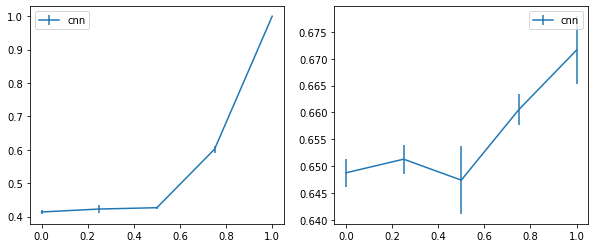

In [18]:
plot_corr_strength(2)

### Model Parameters

In [11]:
# Vbranch params
shared_frac_list = [0.] #, 0.25, 0.5, 0.75, 1.]
num_branches = 1

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    inputs = tf.placeholder('float32', [None, 32,32,3])
    model = build_model(num_branches, frac, compile_loss=False)
    model.summary()
    vbranch_params.append(model.count_parameters())

i   Layer name                      Output shape     Parameters           Num param  Inbound            
--------------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                      
--------------------------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,32]  [3,3,3,32] [32]      896        input:0            
--------------------------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,32]  [32] [32]            64         conv2d_1_1         
--------------------------------------------------------------------------------------------------------
2   relu_1_1 (Activation)           [None,32,32,32]                       0          bn_1_1             
-------------------------------------------------------

In [21]:
param_ratio = [p / vbranch_params[-1] for p in vbranch_params]
ideal_ratio = num_branches - np.array(shared_frac_list)**2 * (num_branches-1)

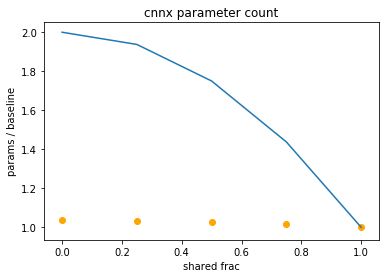

In [22]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
# plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()